In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider
import lab.functions as func

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter, temporal_train_test_split
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error, MeanAbsoluteScaledError, mean_absolute_scaled_error

SEED=0
np.random.seed(SEED)

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

investingdotcom_tickers = ["DAILY_TTF_PRICE", "MONTHLY_TTF_PRICE"]
investingdotcom_provider = GenericDataProvider("datalake/clean/investingdotcom/", want_metadata=False, tickers=investingdotcom_tickers)
print(investingdotcom_tickers)

marketwatch_tickers = ["DAILY_COAL_PRICE"]
marketwatch_provider = GenericDataProvider("datalake/clean/marketwatch/", want_metadata=False, tickers=marketwatch_tickers)
print(marketwatch_tickers)

icap_tickers = ["CO2_EUA_PRICE"]
icap_provider = GenericDataProvider("datalake/clean/ICAP/", want_metadata=False, tickers=icap_tickers)
print(icap_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']
['DAILY_TTF_PRICE', 'MONTHLY_TTF_PRICE']
['DAILY_COAL_PRICE']
['CO2_EUA_PRICE']


In [5]:
forecasting_horizon = 30
fh = list(range(1, forecasting_horizon+1))

nb_windows = 10
step_size = 1

model = RandomForestRegressor()

In [19]:
# start_index="2021-04-01"
start_index="2014-01-01"
end_index="2023-03-31"

In [20]:
esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", start_index=start_index, end_index=end_index, resample_by="D", group_mode="mean")
esios_df = esios_provider.get_all_series(freq="H", start_index=start_index, end_index=end_index, resample_by="D", group_mode="sum")
# ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[0], freq="D", start_index=start_index, end_index=end_index)
# coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", start_index=start_index, end_index=end_index)
# co2_df = icap_provider.get_series(icap_tickers[0], freq="D", start_index=start_index, end_index=end_index)

contamination = 0.01
esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
# X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)
lags = []
date_features = ["day", "day_of_week", "week_of_year", "month"]

df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)
y_date_features = df_date_features.iloc[:, 0]
X_date_features = df_date_features.iloc[:, 1:]

y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test = temporal_train_test_split(y_date_features, X_date_features, test_size=forecasting_horizon)

In [15]:
y_date_features_train

DATE
2021-04-01     52.728750
2021-04-02     49.622917
2021-04-03     34.520417
2021-04-04     28.296250
2021-04-05     45.669167
                 ...    
2023-02-25    142.162500
2023-02-26     79.534583
2023-02-27    118.936250
2023-02-28    133.139583
2023-03-01    145.940000
Freq: D, Name: PRECIO_MERCADO_SPOT_DIARIO, Length: 700, dtype: float64

In [16]:
X_date_features_train

,DEMANDA_REAL,GENERACIÓN_MEDIDA_EÓLICA,GENERACIÓN_MEDIDA_HIDRÁULICA,GENERACIÓN_MEDIDA_NUCLEAR,GENERACIÓN_MEDIDA_SOLAR,GENERACIÓN_MEDIDA_CICLO_COMBINADO,GENERACIÓN_MEDIDA_CARBÓN,month,day,hour,day_of_week,week_of_year
DATE,,,,,,,,,,,,
2021-04-01,571979.833333,163987.169,78543.451,146002.858,57945.194,62667.983,8255.662,4,1,0,3,13
2021-04-02,528189.000000,81765.675,74839.128,145981.370,58507.915,77253.592,7259.649,4,2,0,4,13
2021-04-03,547406.333333,232788.714,53609.954,145929.520,66985.965,46908.126,4112.972,4,3,0,5,13
2021-04-04,522330.666667,180085.004,53386.614,146071.511,82233.688,37444.805,8578.119,4,4,0,6,13
2021-04-05,574848.666667,114728.866,70701.771,145995.149,88601.167,35212.595,9681.668,4,5,0,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-25,628002.250000,110835.782,81490.109,146106.528,71316.081,140122.257,14140.332,2,25,0,5,8
2023-02-26,589932.666667,353738.740,41423.378,146080.994,84228.893,61722.334,11373.946,2,26,0,6,8
2023-02-27,721794.083333,395868.896,46557.830,146033.853,113713.264,73129.263,14534.248,2,27,0,0,9


76.37453930555557
1.578430250855601
4.294984441089381


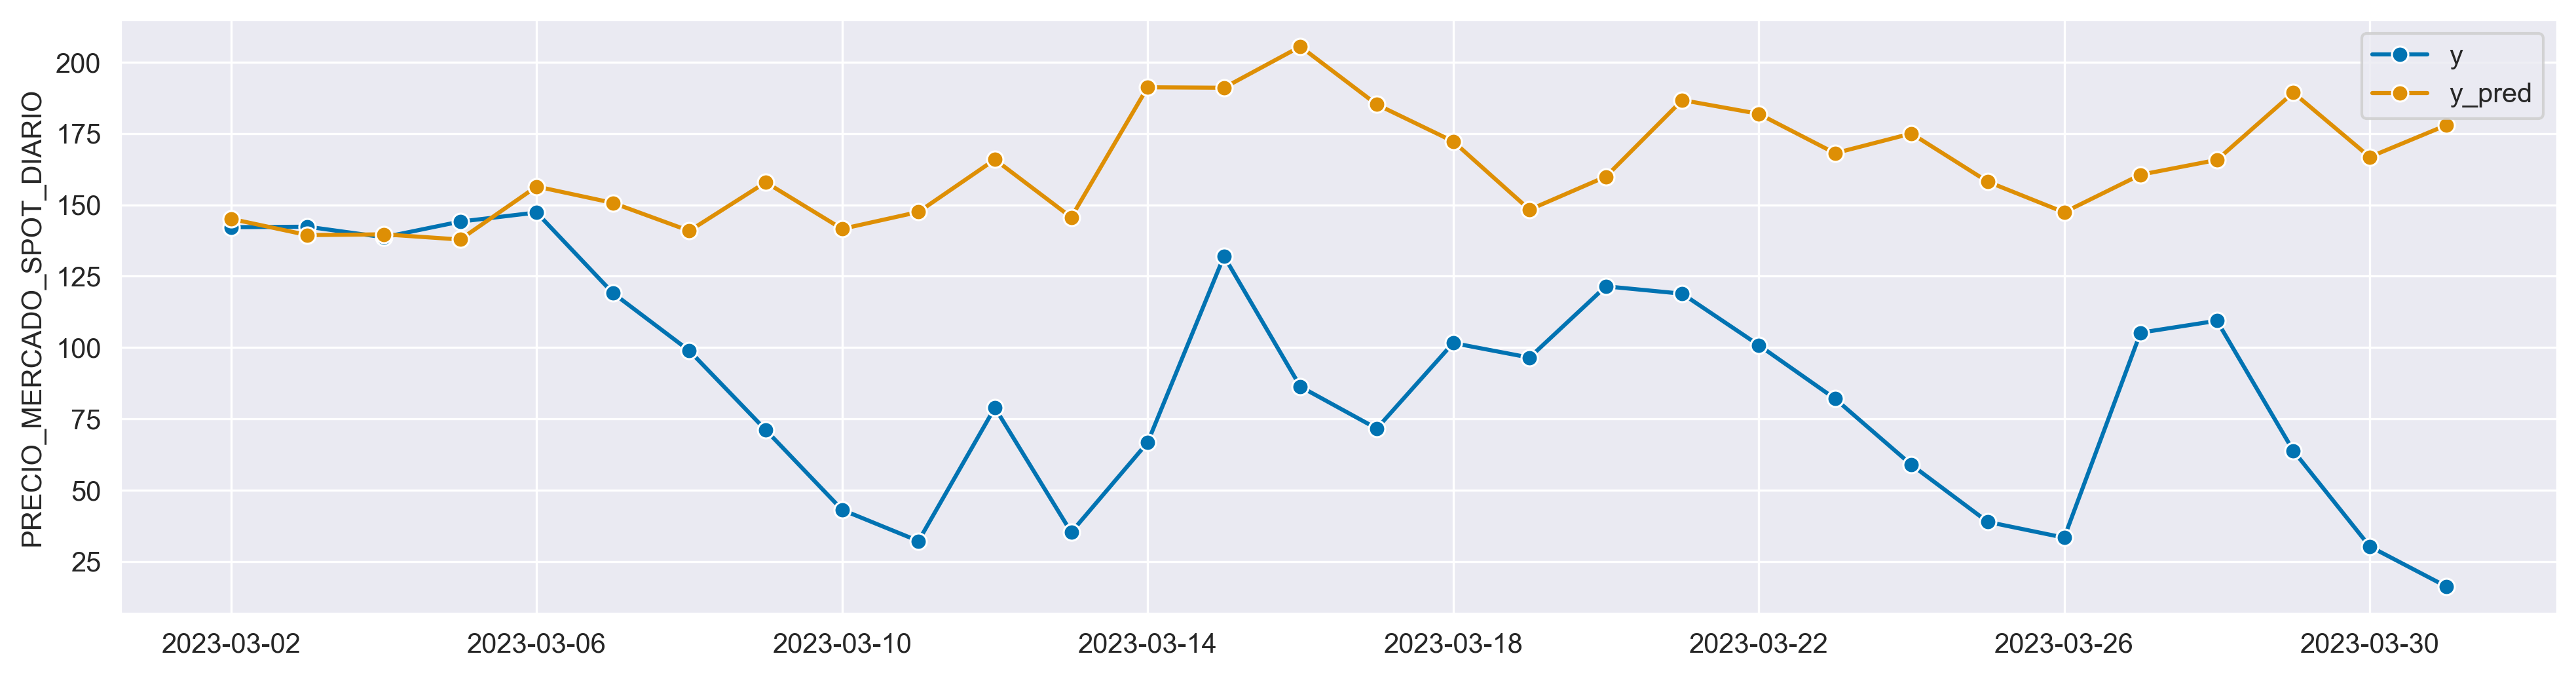

In [20]:
forecaster = make_reduction(model, strategy="direct", window_length=12, windows_identical=True)
forecaster.fit(y_date_features_train, X=X_date_features_train, fh=list(range(1, forecasting_horizon + 1)))

y_pred = forecaster.predict(X=X_date_features_test)
plot_series(y_date_features_test, y_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_date_features_test, y_pred))
print(mean_absolute_percentage_error(y_date_features_test, y_pred))
print(mean_absolute_scaled_error(y_date_features_test, y_pred, y_train=y_date_features_train))

50.30366513888889
1.0893845213250755
2.8288675920770117


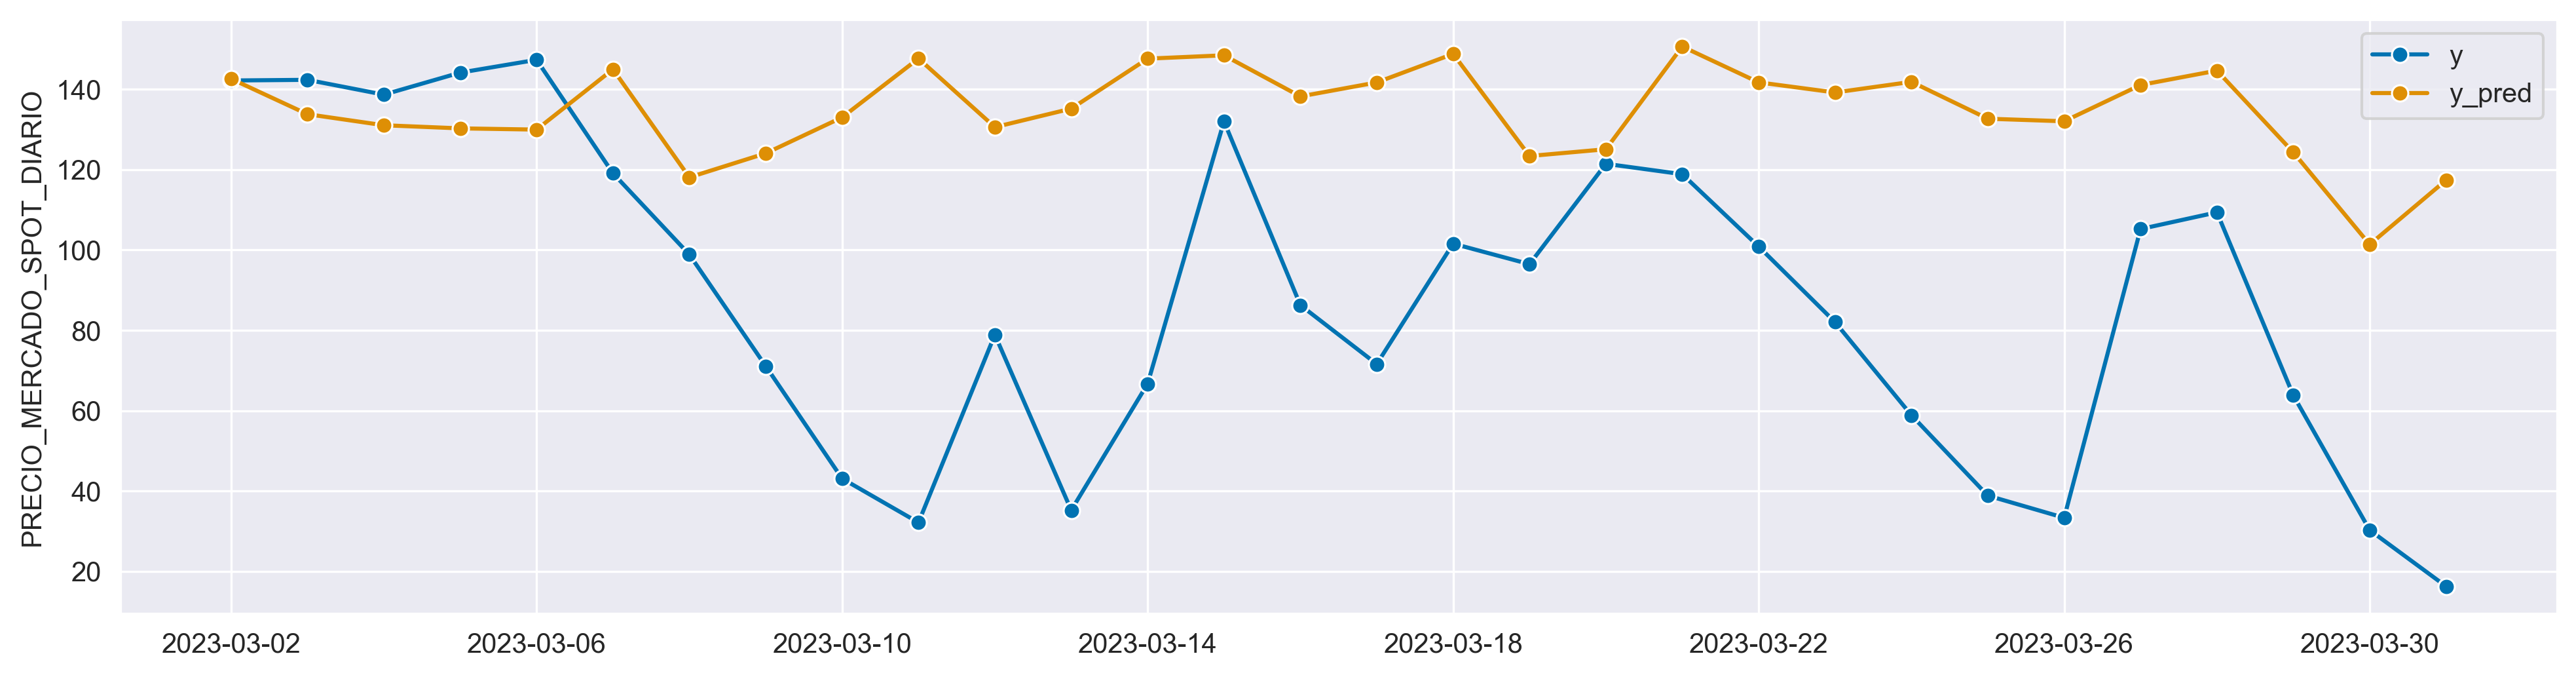

In [19]:
forecaster = make_reduction(model, strategy="direct", window_length=12, windows_identical=True)
forecaster.fit(y_date_features_train, fh=list(range(1, forecasting_horizon + 1)))

y_pred = forecaster.predict()
plot_series(y_date_features_test, y_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_date_features_test, y_pred))
print(mean_absolute_percentage_error(y_date_features_test, y_pred))
print(mean_absolute_scaled_error(y_date_features_test, y_pred, y_train=y_date_features_train))

In [ ]:
start_index="2021-04-01"
end_index="2023-03-31"

In [24]:
esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", start_index=start_index, end_index=end_index, resample_by="D", group_mode="mean")
esios_df = esios_provider.get_all_series(freq="H", start_index=start_index, end_index=end_index, resample_by="D", group_mode="sum")
# ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[0], freq="D", start_index=start_index, end_index=end_index)
# coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", start_index=start_index, end_index=end_index)
# co2_df = icap_provider.get_series(icap_tickers[0], freq="D", start_index=start_index, end_index=end_index)

contamination = 0.01
esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
# X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)
lags = []
date_features = ["day", "day_of_week", "week_of_year", "month"]

df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)
y_date_features = df_date_features.iloc[:, 0]
X_date_features = df_date_features.iloc[:, -4:]

y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test = temporal_train_test_split(y_date_features, X_date_features, test_size=forecasting_horizon)

In [25]:
X_date_features_train

,day,hour,day_of_week,week_of_year
DATE,,,,
2021-04-01,1,0,3,13
2021-04-02,2,0,4,13
2021-04-03,3,0,5,13
2021-04-04,4,0,6,13
2021-04-05,5,0,0,14
...,...,...,...,...
2023-02-25,25,0,5,8
2023-02-26,26,0,6,8
2023-02-27,27,0,0,9


90.98306125
1.8152651172097554
5.1165065743710105


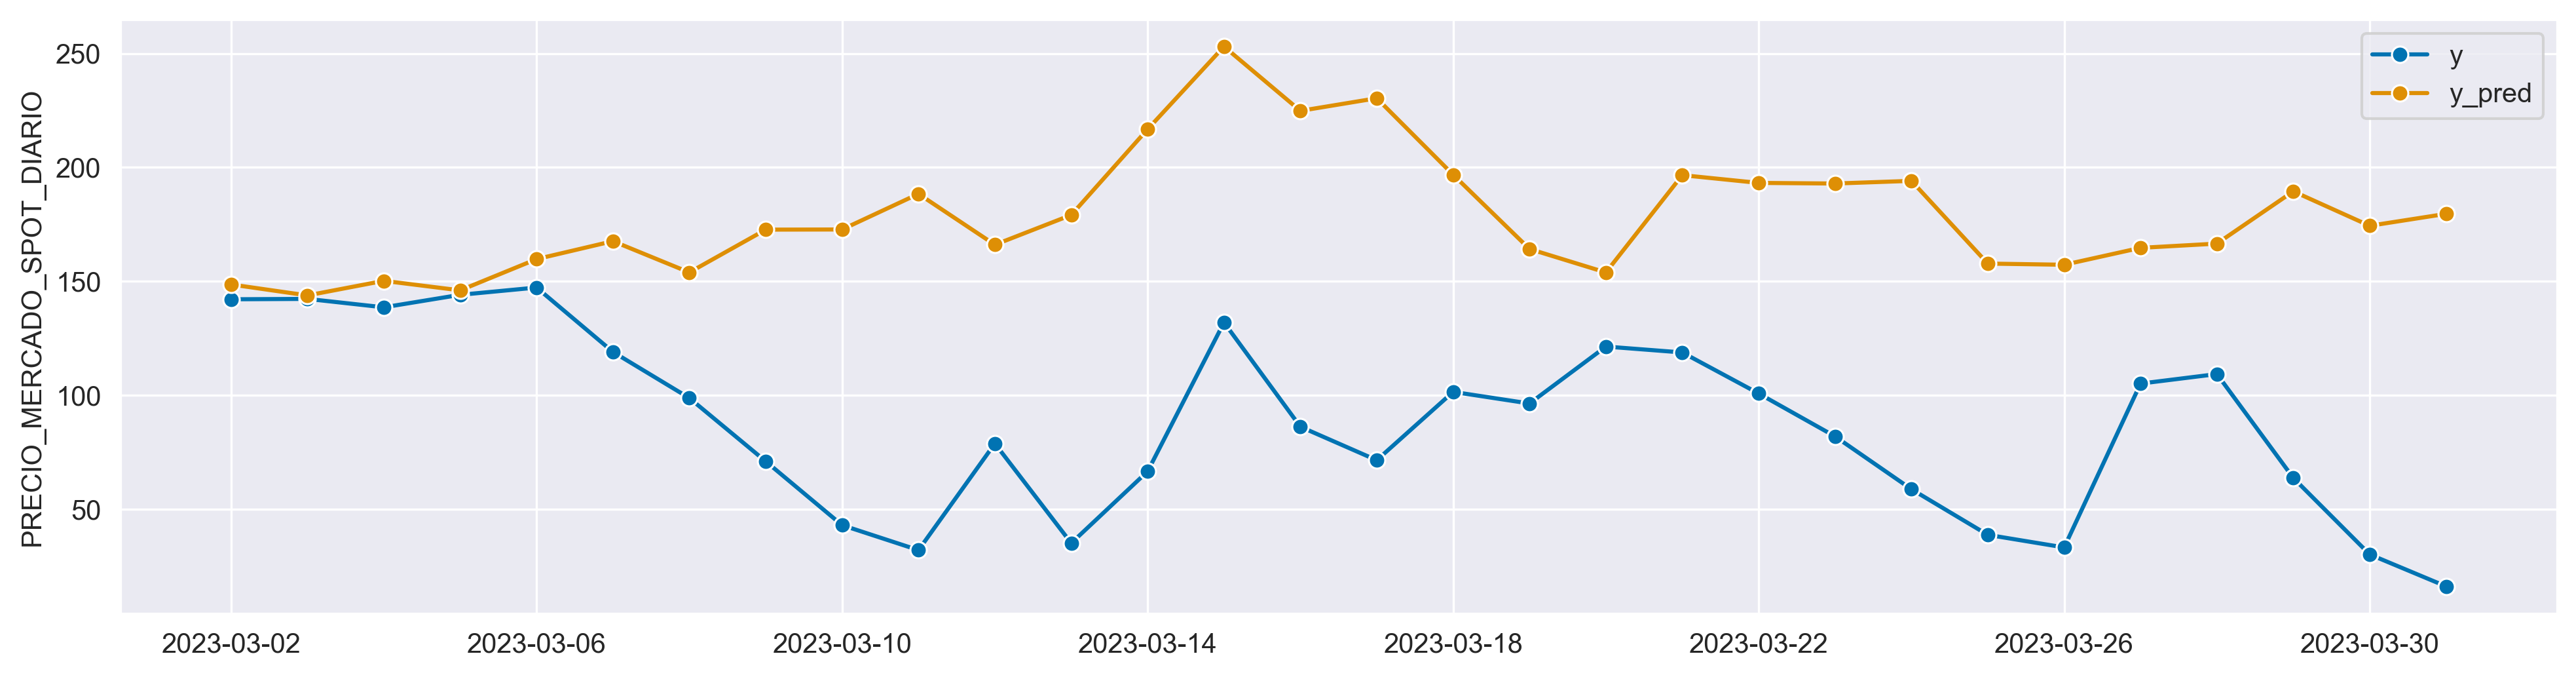

In [26]:
forecaster = make_reduction(model, strategy="direct", window_length=12, windows_identical=True)
forecaster.fit(y_date_features_train, X=X_date_features_train, fh=list(range(1, forecasting_horizon + 1)))

y_pred = forecaster.predict(X=X_date_features_test)
plot_series(y_date_features_test, y_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_date_features_test, y_pred))
print(mean_absolute_percentage_error(y_date_features_test, y_pred))
print(mean_absolute_scaled_error(y_date_features_test, y_pred, y_train=y_date_features_train))

In [45]:
esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", start_index=start_index,
                                       end_index=end_index, resample_by="D", group_mode="mean")
esios_df = esios_provider.get_all_series(freq="H", start_index=start_index, end_index=end_index, resample_by="D",
                                         group_mode="sum")
# ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[0], freq="D", start_index=start_index, end_index=end_index)
# coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", start_index=start_index, end_index=end_index)
# co2_df = icap_provider.get_series(icap_tickers[0], freq="D", start_index=start_index, end_index=end_index)

contamination = 0.01
esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
# X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)
lags = [2, 6, 7, 13, 14, 28, 30, 31]
date_features = ["day", "day_of_week", "week_of_year", "month"]

df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)
y_date_features = df_date_features.iloc[:, 0]
X_date_features = pd.concat([df_date_features.iloc[:, -4:], df_date_features.iloc[:, :len(lags)+1]], axis=1)

y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test = temporal_train_test_split(
    y_date_features, X_date_features, test_size=forecasting_horizon)

In [46]:
X_date_features_test

,day,hour,day_of_week,week_of_year,PRECIO_MERCADO_SPOT_DIARIO,PRECIO_MERCADO_SPOT_DIARIO_shift2,PRECIO_MERCADO_SPOT_DIARIO_shift6,PRECIO_MERCADO_SPOT_DIARIO_shift7,PRECIO_MERCADO_SPOT_DIARIO_shift13,PRECIO_MERCADO_SPOT_DIARIO_shift14,PRECIO_MERCADO_SPOT_DIARIO_shift28,PRECIO_MERCADO_SPOT_DIARIO_shift30,PRECIO_MERCADO_SPOT_DIARIO_shift31
DATE,,,,,,,,,,,,,
2023-03-02,2,0,3,9,142.169167,133.139583,149.103750,140.519583,134.664167,144.518750,138.709583,127.422083,135.713750
2023-03-03,3,0,4,9,142.333750,145.940000,142.162500,149.103750,128.291250,134.664167,139.927500,127.979167,127.422083
2023-03-04,4,0,5,9,138.646250,142.169167,79.534583,142.162500,122.898750,128.291250,123.338750,138.709583,127.979167
2023-03-05,5,0,6,9,144.128750,142.333750,118.936250,79.534583,135.710000,122.898750,79.429583,139.927500,138.709583
2023-03-06,6,0,0,10,147.316667,138.646250,133.139583,118.936250,151.033333,135.710000,136.309167,123.338750,139.927500
2023-03-07,7,0,1,10,119.070000,144.128750,145.940000,133.139583,144.245833,151.033333,137.390000,79.429583,123.338750
2023-03-08,8,0,2,10,98.854167,147.316667,142.169167,145.940000,140.519583,144.245833,138.334167,136.309167,79.429583
2023-03-09,9,0,3,10,71.080833,119.070000,142.333750,142.169167,149.103750,140.519583,144.839583,137.390000,136.309167
2023-03-10,10,0,4,10,43.091250,98.854167,138.646250,142.333750,142.162500,149.103750,141.955417,138.334167,137.390000


65.67977896534696
1.3682278655213864
3.1381697856581354


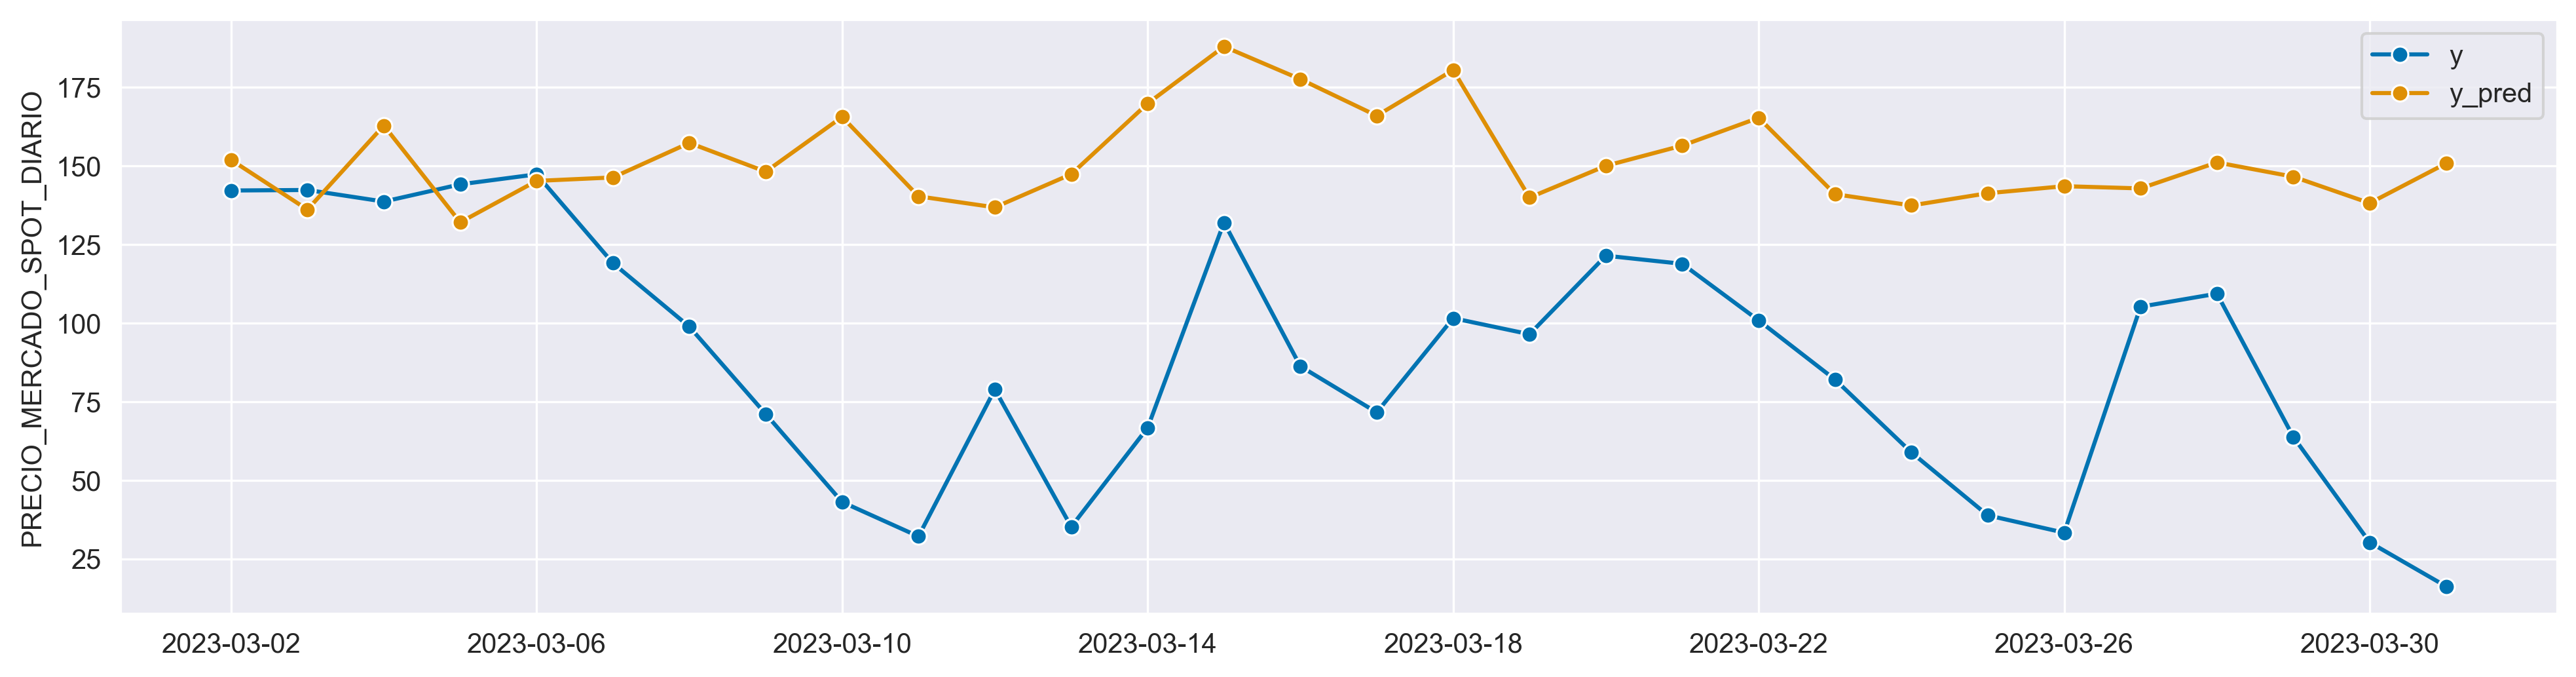

In [47]:
forecaster = make_reduction(GradientBoostingRegressor(), strategy="direct", window_length=1, windows_identical=True)
forecaster.fit(y_date_features_train[-500:], X=X_date_features_train.iloc[-500:,:], fh=list(range(1, forecasting_horizon + 1)))

y_pred = forecaster.predict(X=X_date_features_test)
plot_series(y_date_features_test, y_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_date_features_test, y_pred))
print(mean_absolute_percentage_error(y_date_features_test, y_pred))
print(mean_absolute_scaled_error(y_date_features_test, y_pred, y_train=y_date_features_train[-500:]))

In [48]:
X_date_features_train.iloc[-500:,:]

,day,hour,day_of_week,week_of_year,PRECIO_MERCADO_SPOT_DIARIO,PRECIO_MERCADO_SPOT_DIARIO_shift2,PRECIO_MERCADO_SPOT_DIARIO_shift6,PRECIO_MERCADO_SPOT_DIARIO_shift7,PRECIO_MERCADO_SPOT_DIARIO_shift13,PRECIO_MERCADO_SPOT_DIARIO_shift14,PRECIO_MERCADO_SPOT_DIARIO_shift28,PRECIO_MERCADO_SPOT_DIARIO_shift30,PRECIO_MERCADO_SPOT_DIARIO_shift31
DATE,,,,,,,,,,,,,
2021-10-18,18,0,0,42,227.023750,224.801667,183.006250,187.021250,207.615833,189.739167,155.091667,158.081667,166.778750
2021-10-19,19,0,1,42,204.090000,210.525000,189.401250,183.006250,231.584583,207.615833,152.417917,145.280417,158.081667
2021-10-20,20,0,2,42,203.147917,227.023750,217.871250,189.401250,284.740000,231.584583,175.559583,155.091667,145.280417
2021-10-21,21,0,3,42,207.353750,204.090000,232.382083,217.871250,230.350833,284.740000,166.141667,152.417917,155.091667
2021-10-22,22,0,4,42,204.015417,203.147917,224.801667,232.382083,220.592500,230.350833,174.836667,175.559583,152.417917
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-25,25,0,5,8,142.162500,140.519583,122.898750,128.291250,137.752500,131.803333,41.932500,66.482083,92.035000
2023-02-26,26,0,6,8,79.534583,149.103750,135.710000,122.898750,146.580833,137.752500,71.104167,45.305417,66.482083
2023-02-27,27,0,0,9,118.936250,142.162500,151.033333,135.710000,142.668750,146.580833,135.713750,41.932500,45.305417


### scikit-learn model instead of sktime

In [66]:
esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", start_index=start_index,
                                       end_index=end_index, resample_by="D", group_mode="mean")
esios_df = esios_provider.get_all_series(freq="H", start_index=start_index, end_index=end_index, resample_by="D",
                                         group_mode="sum")
# ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[0], freq="D", start_index=start_index, end_index=end_index)
# coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", start_index=start_index, end_index=end_index)
# co2_df = icap_provider.get_series(icap_tickers[0], freq="D", start_index=start_index, end_index=end_index)

contamination = 0.01
esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
# X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)
lags = [1, 2, 6, 7, 13, 14, 28, 30, 31]
date_features = ["day", "day_of_week", "week_of_year", "month"]

df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)
y_date_features = df_date_features.iloc[:, 0]
X_date_features = pd.concat([df_date_features.iloc[:, -4:], df_date_features.iloc[:, :len(lags)+1]], axis=1)

y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test = temporal_train_test_split(
    y_date_features, X_date_features, test_size=forecasting_horizon)

In [70]:
X_date_features

,day,hour,day_of_week,week_of_year,PRECIO_MERCADO_SPOT_DIARIO,PRECIO_MERCADO_SPOT_DIARIO_shift1,PRECIO_MERCADO_SPOT_DIARIO_shift2,PRECIO_MERCADO_SPOT_DIARIO_shift6,PRECIO_MERCADO_SPOT_DIARIO_shift7,PRECIO_MERCADO_SPOT_DIARIO_shift13,PRECIO_MERCADO_SPOT_DIARIO_shift14,PRECIO_MERCADO_SPOT_DIARIO_shift28,PRECIO_MERCADO_SPOT_DIARIO_shift30,PRECIO_MERCADO_SPOT_DIARIO_shift31
DATE,,,,,,,,,,,,,,
2014-02-01,1,0,5,5,10.962917,39.112500,28.153750,24.653750,21.070833,32.730000,43.689167,4.304583,25.704583,5.188333
2014-02-02,2,0,6,5,26.422917,10.962917,39.112500,15.712083,24.653750,38.683333,32.730000,4.925000,40.182500,25.704583
2014-02-03,3,0,0,6,25.793750,26.422917,10.962917,4.842917,15.712083,50.604167,38.683333,13.579167,4.304583,40.182500
2014-02-04,4,0,1,6,23.972917,25.793750,26.422917,29.914583,4.842917,47.027500,50.604167,48.328750,4.925000,4.304583
2014-02-05,5,0,2,6,12.160417,23.972917,25.793750,28.153750,29.914583,44.401250,47.027500,40.833333,13.579167,4.925000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,27,0,0,13,105.196250,33.334583,38.846250,118.847500,121.430417,66.687917,35.215000,118.936250,142.162500,149.103750
2023-03-28,28,0,1,13,109.358750,105.196250,33.334583,100.842500,118.847500,131.988750,66.687917,133.139583,79.534583,142.162500
2023-03-29,29,0,2,13,63.800833,109.358750,105.196250,82.035833,100.842500,86.258750,131.988750,145.940000,118.936250,79.534583


In [67]:
def compute_lag(y, lags):
    name = y.columns[0]

    for lag in lags:
        kwargs = {name+"_shift"+str(lag): y[name].shift(lag)}
        y = y.assign(**kwargs)
        # y = pd.concat([y, y[name].shift(lag)], axis=1)

    y = y.drop(name, axis=1)
    return y


def compute_lag_fh_df(y, lags, fh):
    horizon_values = pd.DataFrame()
    for horizon in reversed(fh):
        kwargs = {name+"_horizon"+str(horizon): y[name].shift(-horizon+1)}
        horizon_values = horizon_values.assign(**kwargs)
    ret =  pd.concat([horizon_values, compute_lag(y, lags)], axis=1)
    return ret


def add_date_features(y, X, lags, fh, date_features):
    y = pd.DataFrame(y)

    if "year" in date_features:
        X['year'] = y.index.year
    if "month" in date_features:
        X['month'] = y.index.month
    if "day" in date_features:
        X['day'] = y.index.day
    if "hour":
        X['hour'] = y.index.hour
    if "day_of_week" in date_features:
        X['day_of_week'] = y.index.day_of_week
    if "day_of_year" in date_features:
        X['day_of_year'] = y.index.day_of_year
    if "week_of_year" in date_features:
        X['week_of_year'] = y.index.weekofyear

    df = pd.concat([compute_lag_fh_df(y, lags, fh), X], axis=1)
    df = df.copy()
    return df.dropna()

In [74]:
X_multioutput =  add_date_features(esios_spot, X, lags, list(range(1,31)), date_features)

In [108]:
y_multioutput_train, y_multioutput_test, X_multioutput_train, X_multioutput_test = temporal_train_test_split(y=X_multioutput.iloc[:,:30], X=X_multioutput.iloc[:,31:], test_size=10)

In [109]:
y_multioutput_train

,PRECIO_MERCADO_SPOT_DIARIO_horizon30,PRECIO_MERCADO_SPOT_DIARIO_horizon29,PRECIO_MERCADO_SPOT_DIARIO_horizon28,PRECIO_MERCADO_SPOT_DIARIO_horizon27,PRECIO_MERCADO_SPOT_DIARIO_horizon26,PRECIO_MERCADO_SPOT_DIARIO_horizon25,PRECIO_MERCADO_SPOT_DIARIO_horizon24,PRECIO_MERCADO_SPOT_DIARIO_horizon23,PRECIO_MERCADO_SPOT_DIARIO_horizon22,PRECIO_MERCADO_SPOT_DIARIO_horizon21,...,PRECIO_MERCADO_SPOT_DIARIO_horizon10,PRECIO_MERCADO_SPOT_DIARIO_horizon9,PRECIO_MERCADO_SPOT_DIARIO_horizon8,PRECIO_MERCADO_SPOT_DIARIO_horizon7,PRECIO_MERCADO_SPOT_DIARIO_horizon6,PRECIO_MERCADO_SPOT_DIARIO_horizon5,PRECIO_MERCADO_SPOT_DIARIO_horizon4,PRECIO_MERCADO_SPOT_DIARIO_horizon3,PRECIO_MERCADO_SPOT_DIARIO_horizon2,PRECIO_MERCADO_SPOT_DIARIO_horizon1
DATE,,,,,,,,,,,,,,,,,,,,,
2014-02-01,0.729167,2.132917,5.656667,27.881667,24.442500,17.642917,34.809583,5.939583,17.220417,18.324167,...,3.204583,0.469583,0.983333,3.299167,4.920417,12.160417,23.972917,25.793750,26.422917,10.962917
2014-02-02,1.310417,0.729167,2.132917,5.656667,27.881667,24.442500,17.642917,34.809583,5.939583,17.220417,...,19.970833,3.204583,0.469583,0.983333,3.299167,4.920417,12.160417,23.972917,25.793750,26.422917
2014-02-03,2.882500,1.310417,0.729167,2.132917,5.656667,27.881667,24.442500,17.642917,34.809583,5.939583,...,19.656250,19.970833,3.204583,0.469583,0.983333,3.299167,4.920417,12.160417,23.972917,25.793750
2014-02-04,18.141250,2.882500,1.310417,0.729167,2.132917,5.656667,27.881667,24.442500,17.642917,34.809583,...,6.634583,19.656250,19.970833,3.204583,0.469583,0.983333,3.299167,4.920417,12.160417,23.972917
2014-02-05,45.733333,18.141250,2.882500,1.310417,0.729167,2.132917,5.656667,27.881667,24.442500,17.642917,...,3.353750,6.634583,19.656250,19.970833,3.204583,0.469583,0.983333,3.299167,4.920417,12.160417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-16,71.590000,86.258750,131.988750,66.687917,35.215000,78.893333,32.151250,43.091250,71.080833,98.854167,...,142.162500,149.103750,140.519583,144.245833,151.033333,135.710000,122.898750,128.291250,134.664167,144.518750
2023-02-17,101.556667,71.590000,86.258750,131.988750,66.687917,35.215000,78.893333,32.151250,43.091250,71.080833,...,79.534583,142.162500,149.103750,140.519583,144.245833,151.033333,135.710000,122.898750,128.291250,134.664167
2023-02-18,96.456250,101.556667,71.590000,86.258750,131.988750,66.687917,35.215000,78.893333,32.151250,43.091250,...,118.936250,79.534583,142.162500,149.103750,140.519583,144.245833,151.033333,135.710000,122.898750,128.291250


In [110]:
model = RandomForestRegressor(random_state=0)
model.fit(X_multioutput_train, y_multioutput_train)

RandomForestRegressor(random_state=0)

In [118]:
y_multioutput_pred = model.predict(X_multioutput_test)
y_multioutput_pred = pd.DataFrame(y_multioutput_pred, index=y_multioutput_test.index, columns=y_multioutput_test.columns)

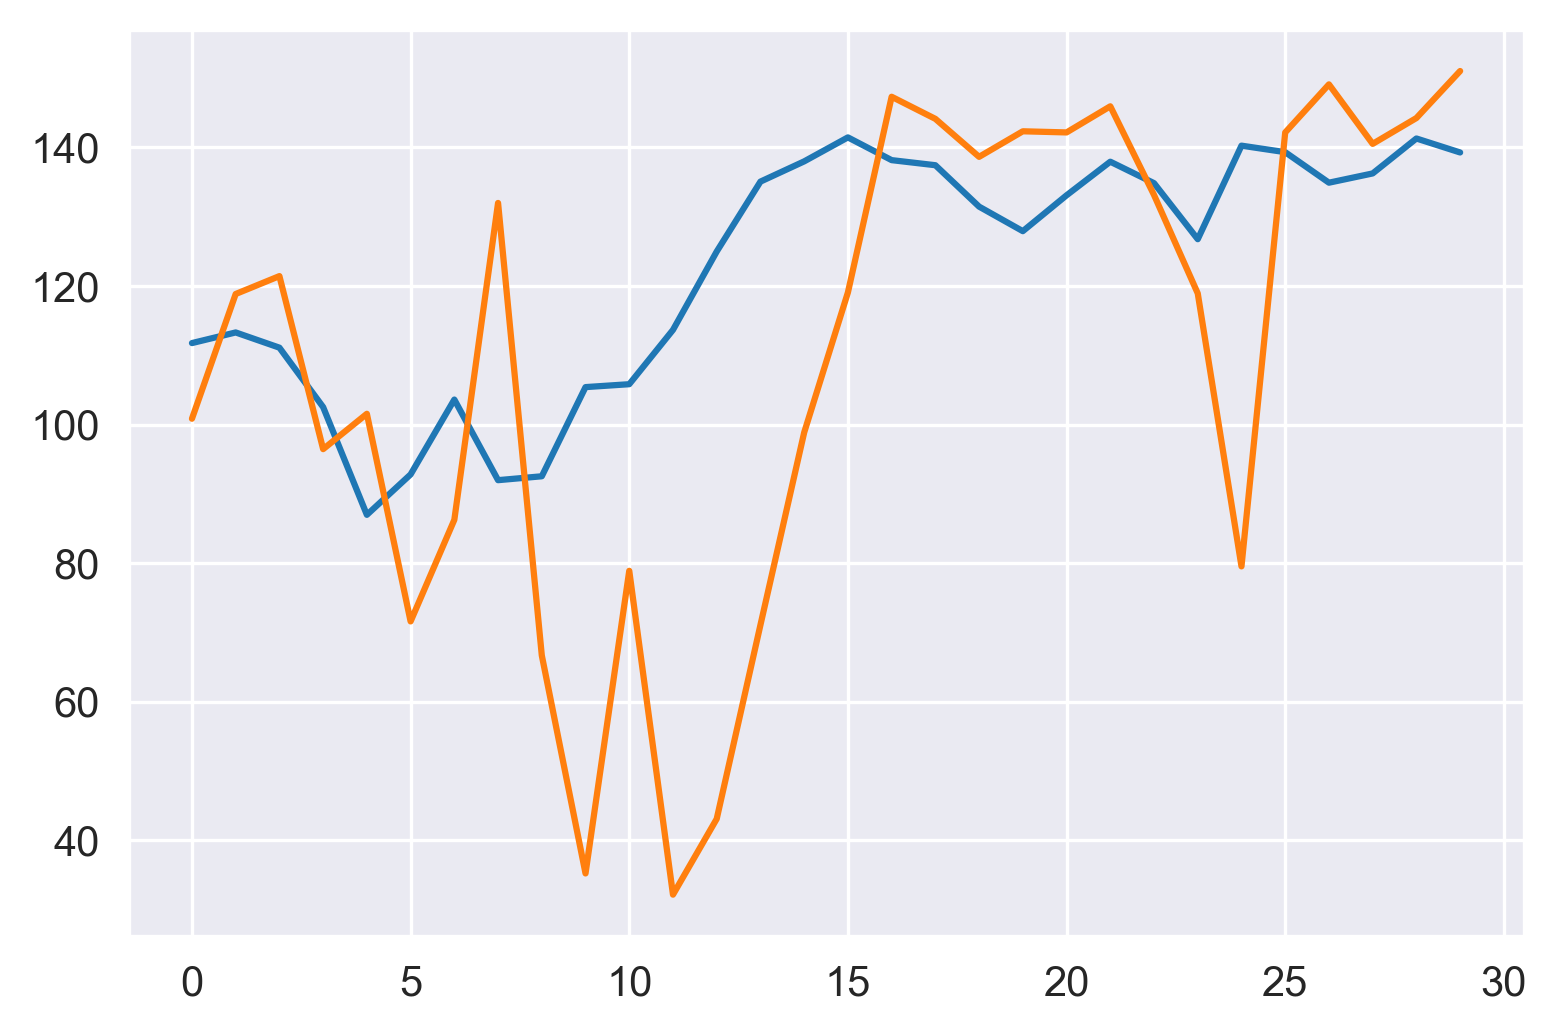

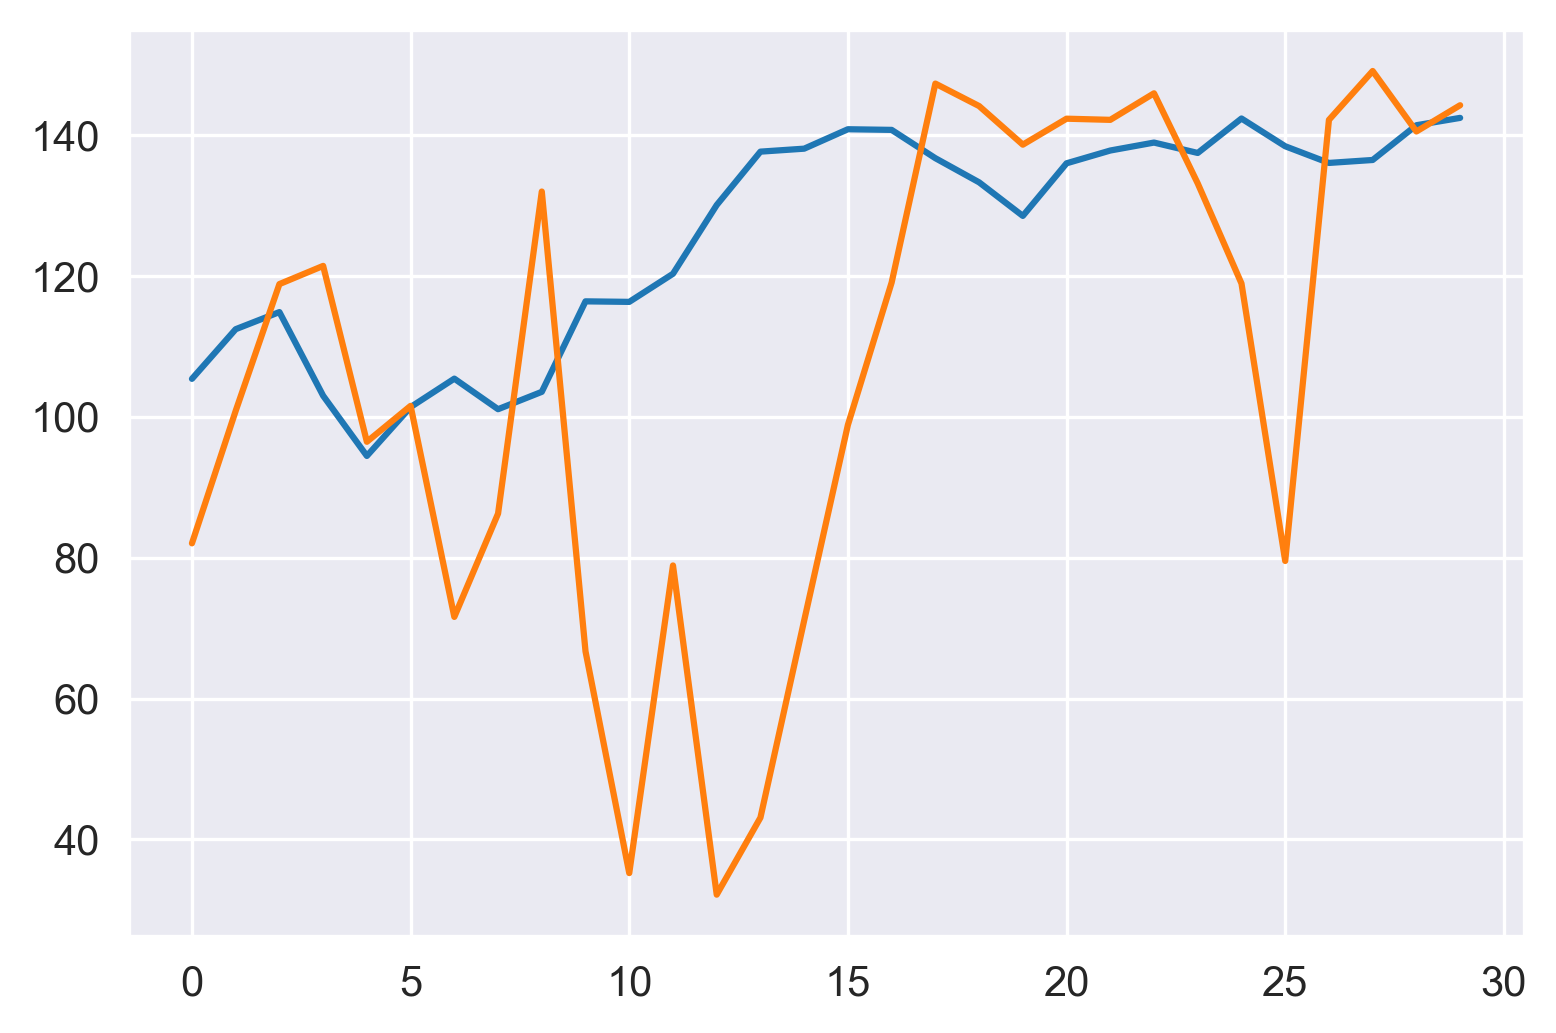

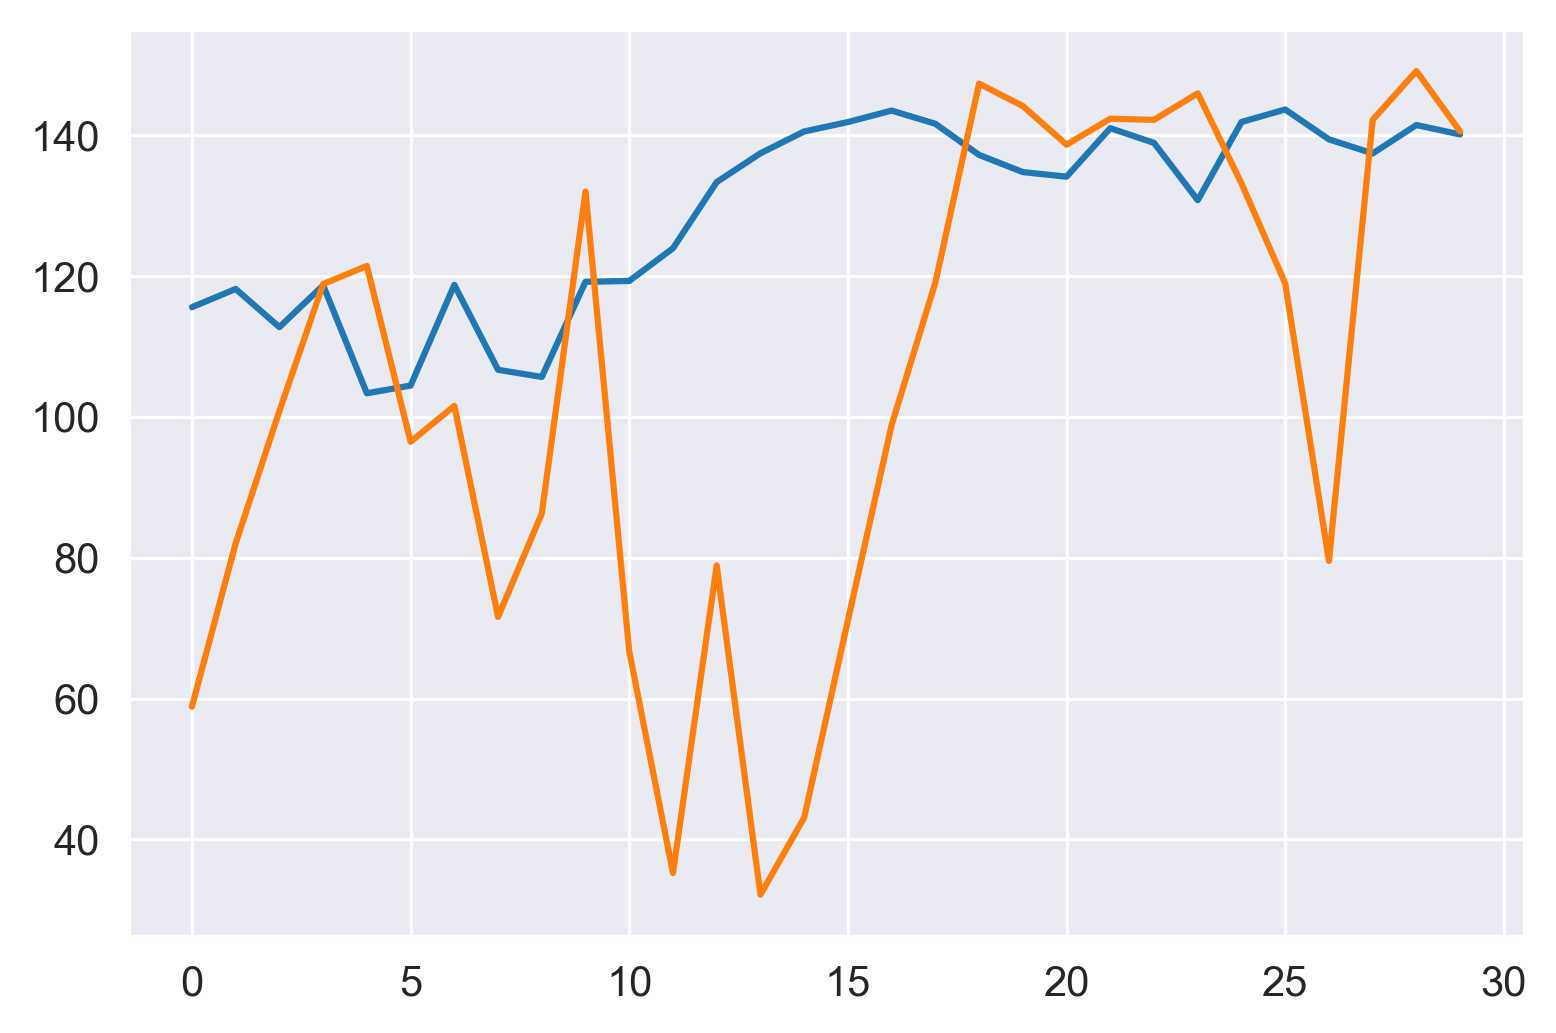

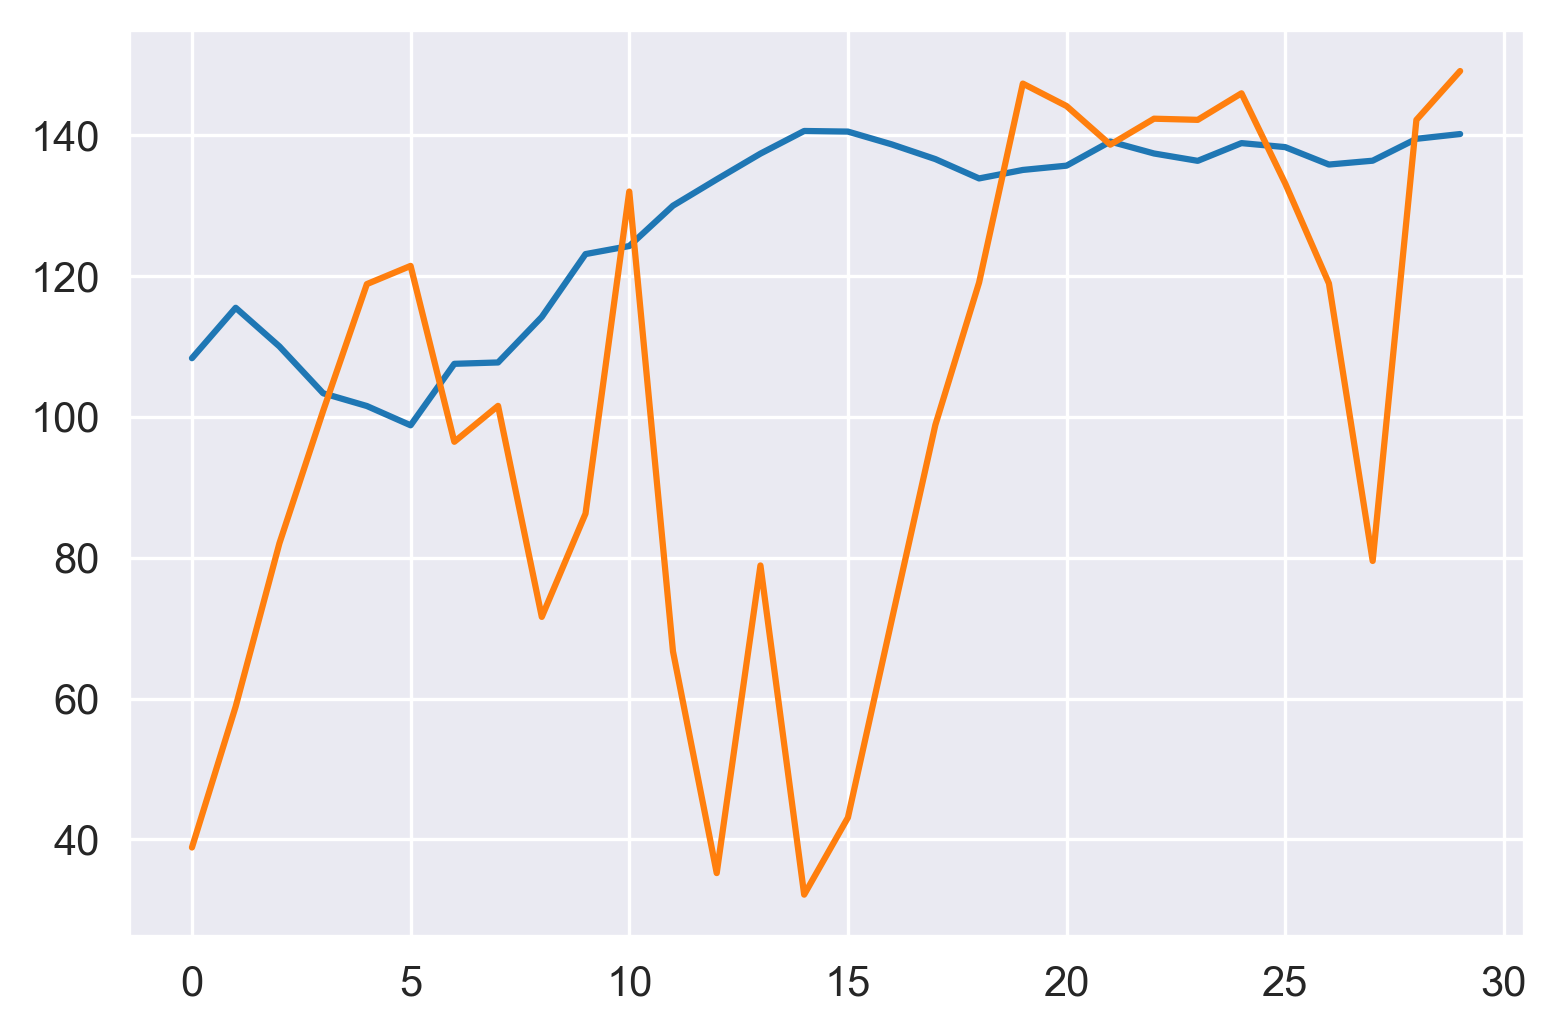

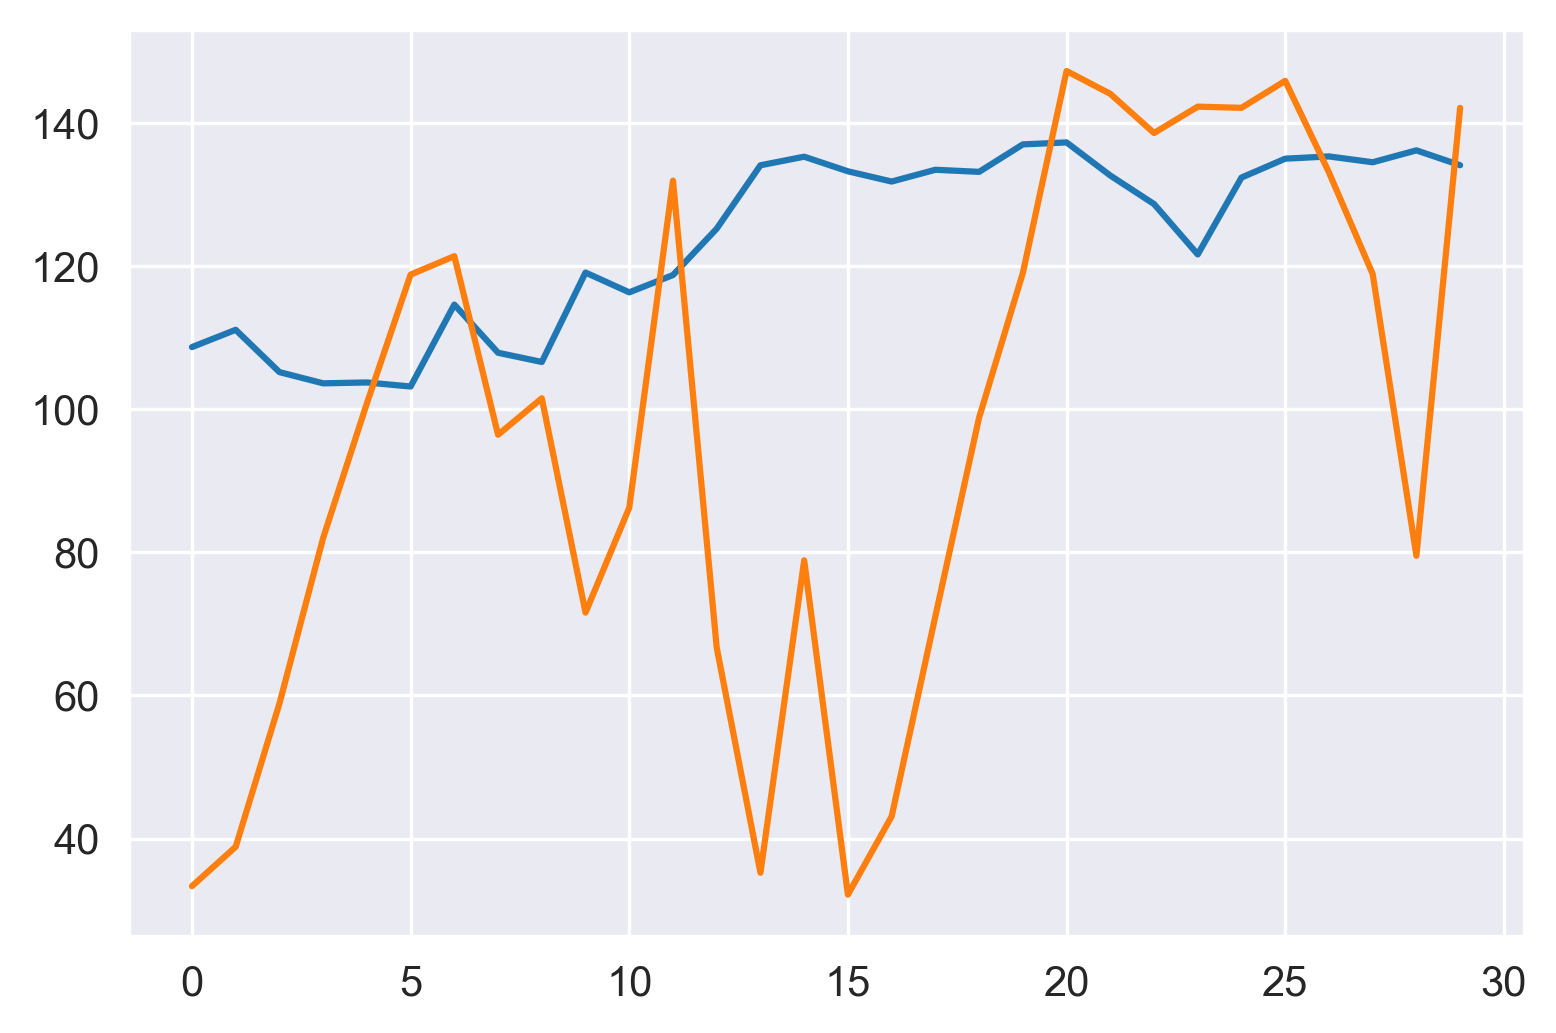

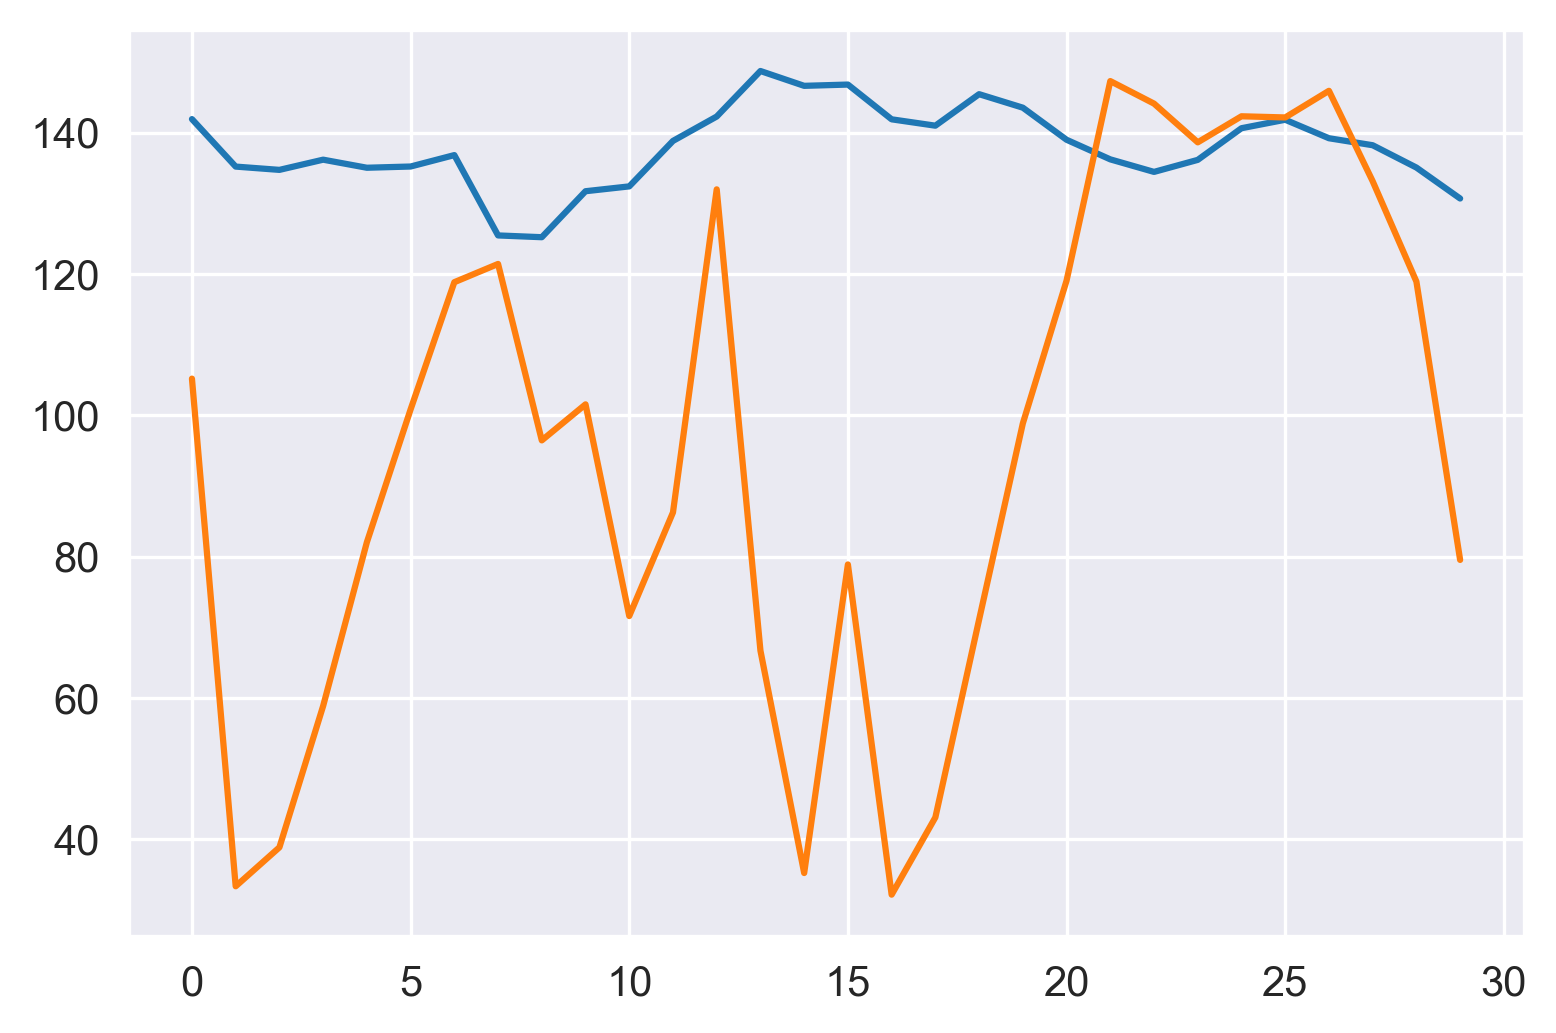

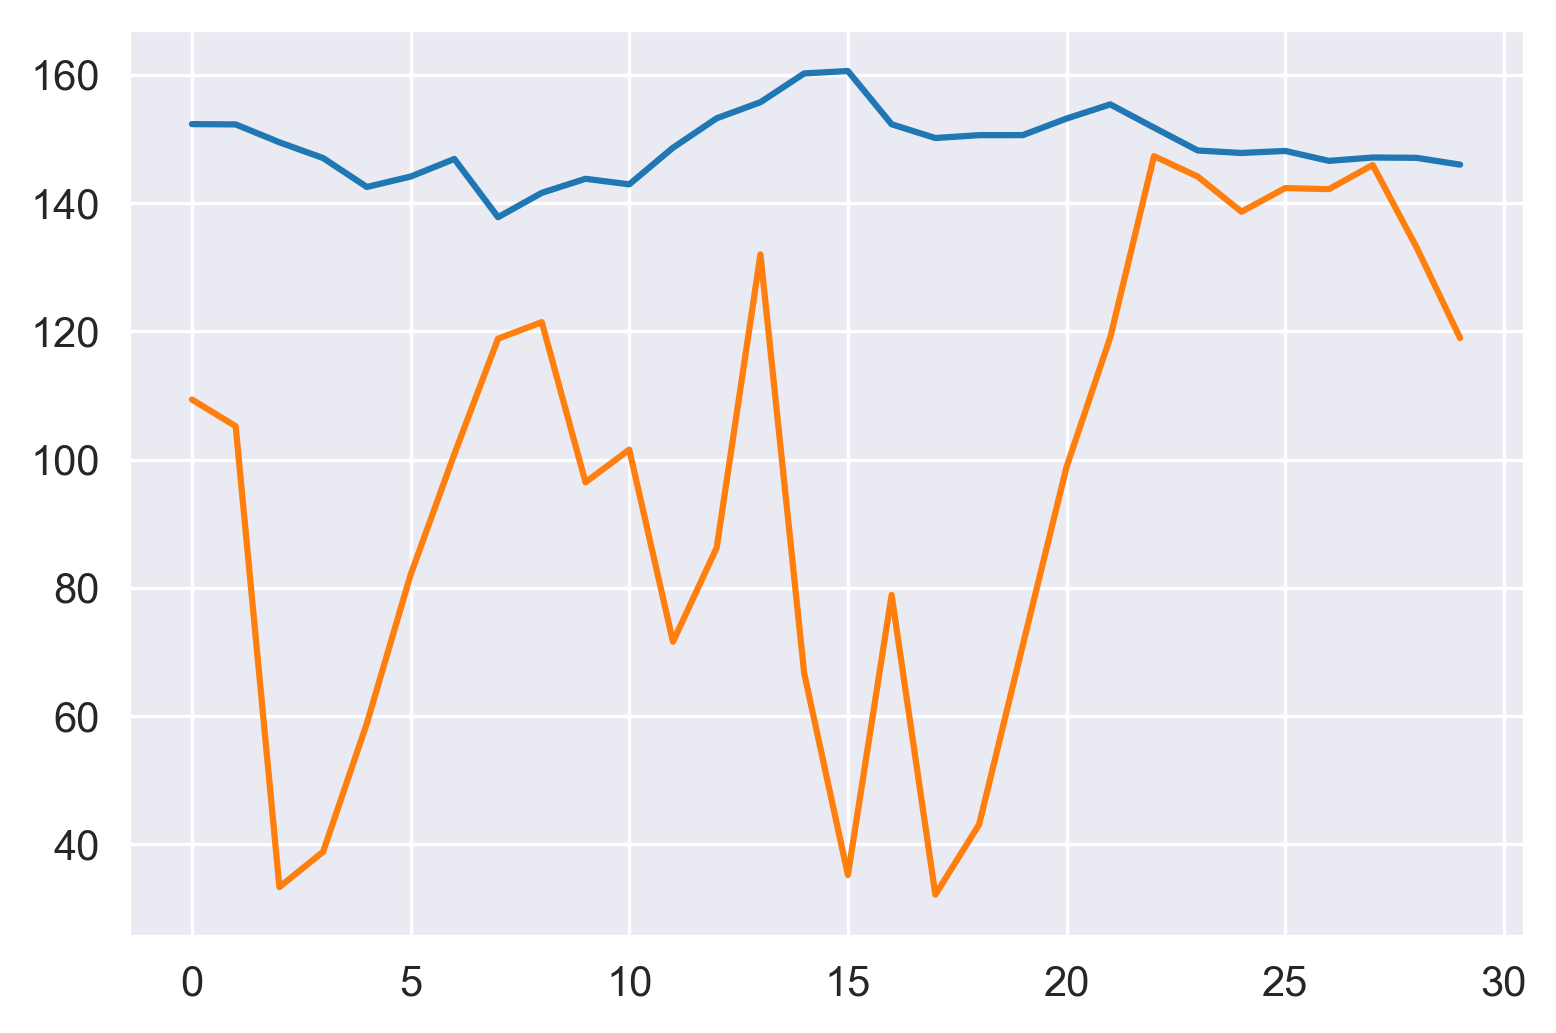

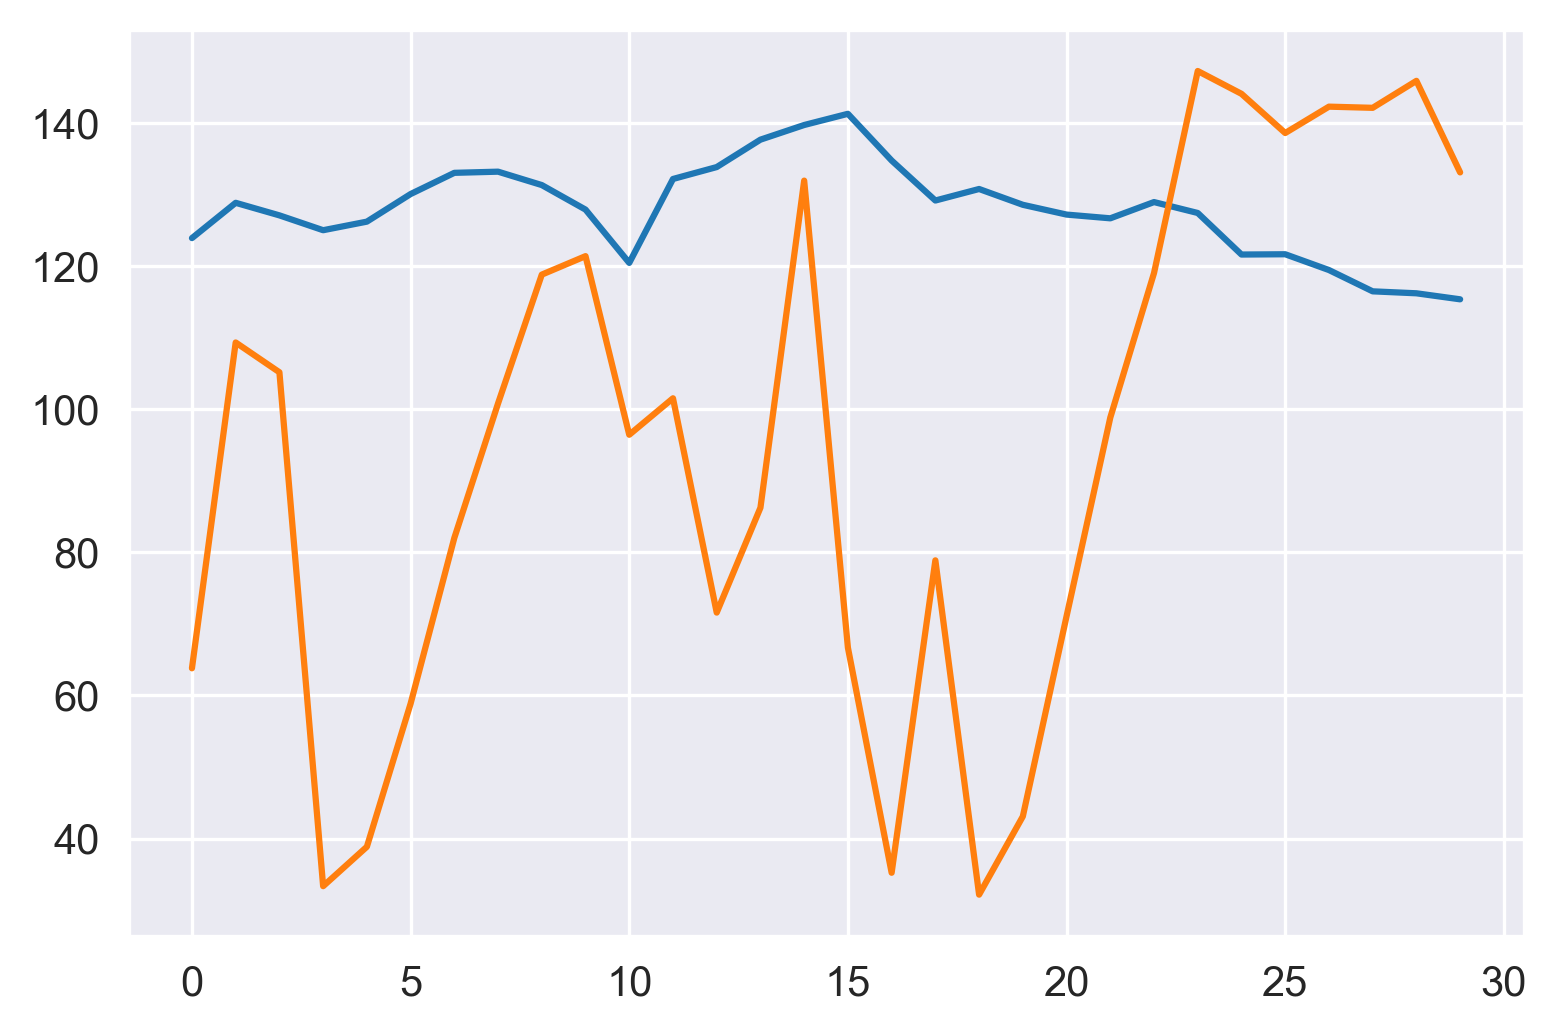

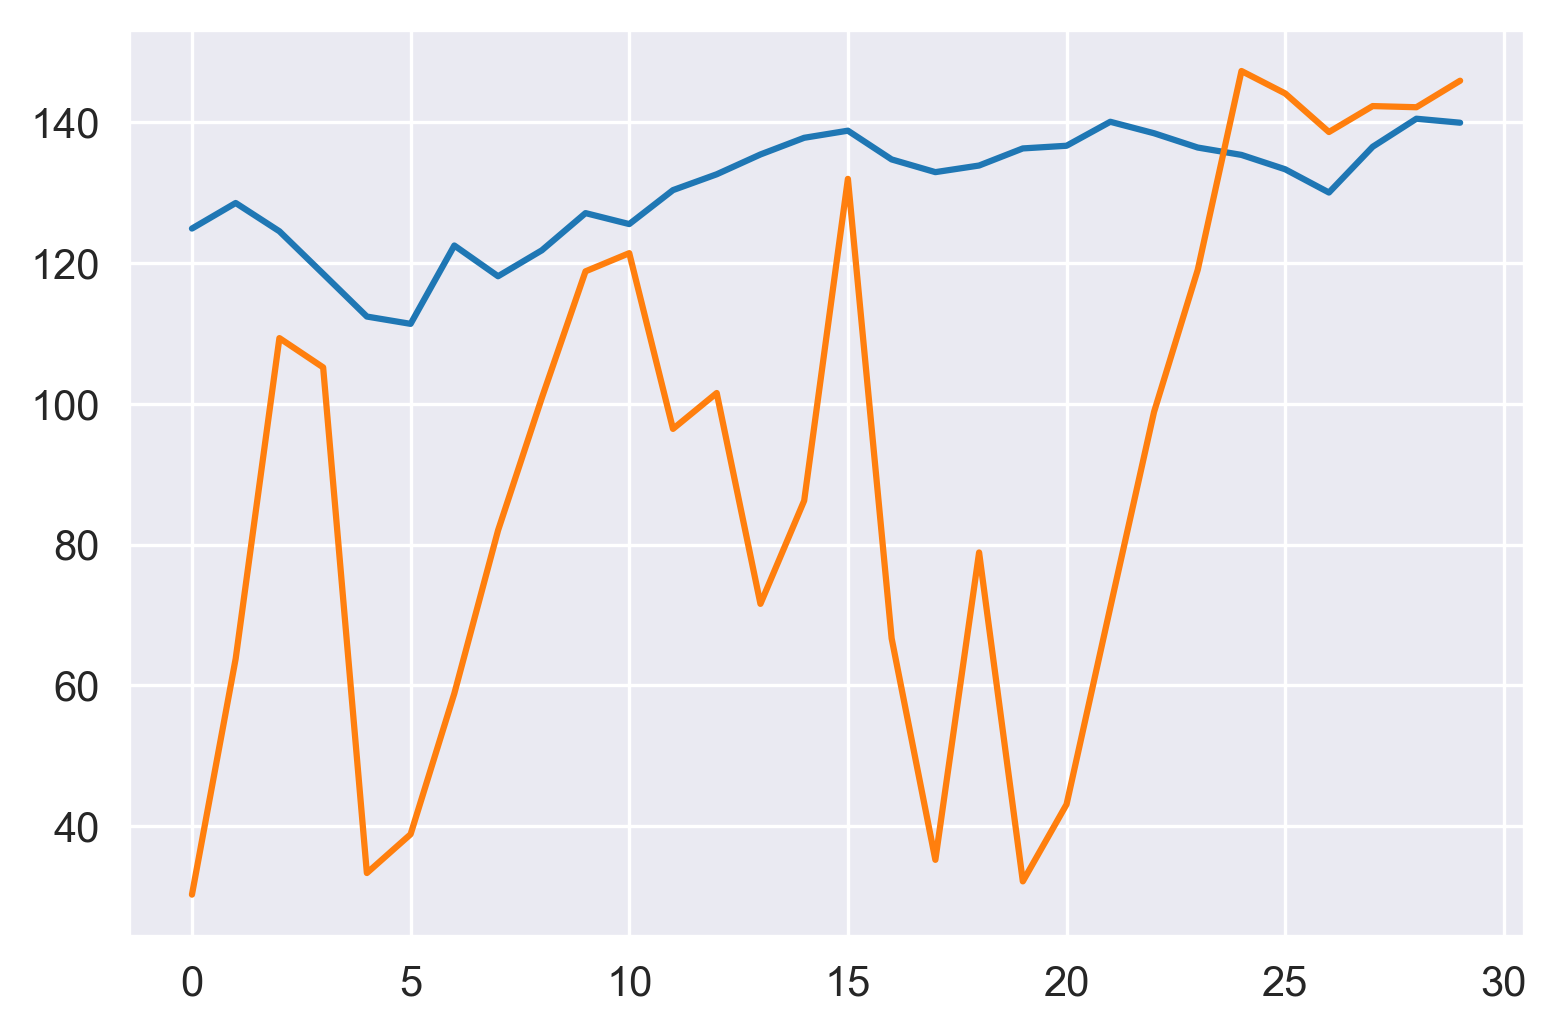

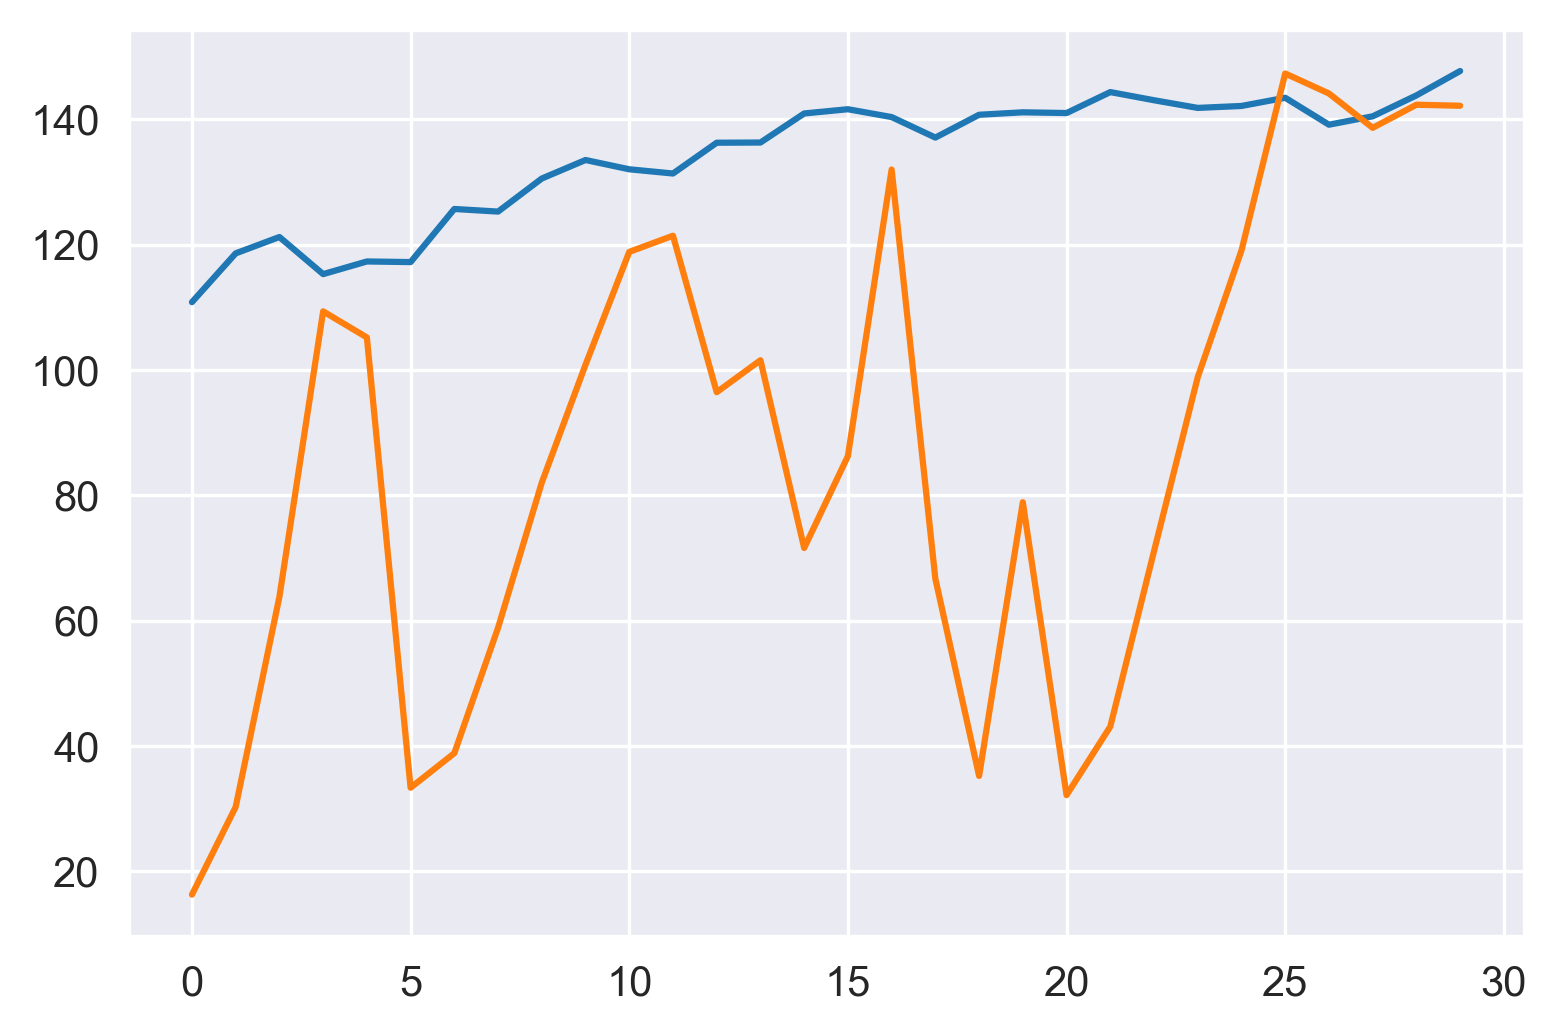

IndexError: single positional indexer is out-of-bounds

In [130]:
for i in range(30):
    y_pred = y_multioutput_pred.iloc[i,:].to_numpy()
    y_test = y_multioutput_test.iloc[i,:].to_numpy()
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.show()

In [101]:
plot_series(y_multioutput_test, y_multioutput_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_date_features_test, y_pred))
print(mean_absolute_percentage_error(y_date_features_test, y_pred))
print(mean_absolute_scaled_error(y_date_features_test, y_pred, y_train=y_date_features_train[-500:]))

ValueError: input must be univariate, but found 30 variables.